In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time # delay within program
from math import *
import random
import pickle
import os

import nidaqmx # laser output
from pyueye import ueye
from pypyueye import Camera

from improc import *

# Inits and checks

In [2]:
templates,bodies = load_templates()
cam,task = init_instruments()

In [3]:
bgs = make_vec_bg(cam,task,[0,1],total_time=20)

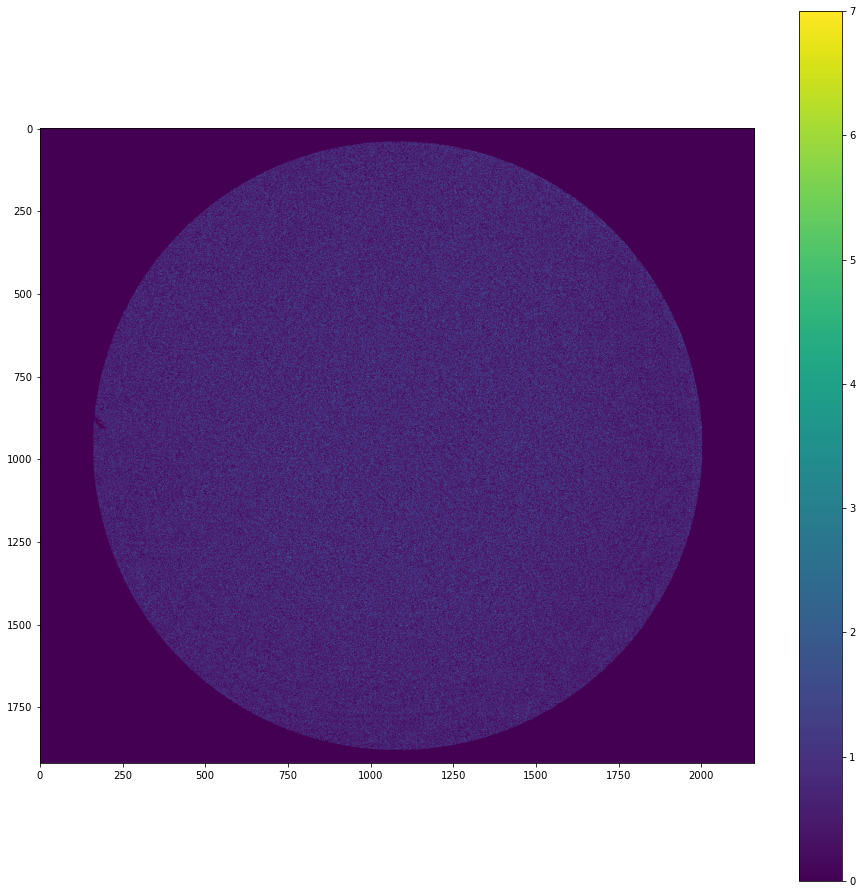

In [31]:
# Check that things are working
plt.figure(figsize=(16,16))
img = grab_im(cam,bgs[0])
plt.imshow(img)
plt.colorbar();

[{'loc': array([1418.76666667,  330.2       ]), 'img': array([[2, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 1, 2, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 2],
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 2]], dtype=uint8), 'scores': array([255912,  97686]), 'angs': array([180,  30]), 'endpts': array([[1413, 1426],
       [ 333,  323]]), 'body': 240}]


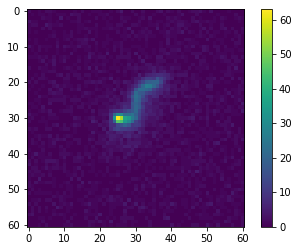

In [5]:
worms = find_worms(img,templates,bodies)
print(worms)
plt.imshow(worms[0]['img'])
plt.colorbar();

# AIY test

In [7]:
track,angs,lights = if_stmt_angle(270,cam,task,bgs,templates,bodies,total_time=300)

Finding orientation
elapsed 2

1
	 1260.96 -391.87
	body 240 head 180 light 0
2
	 1256.9 -398.82
	body 300 head 330 light 0
3
	 1258.12 -401.05
	body 330 head 0 light 0
5
	 1259.11 -402.13
	body 330 head 30 light 0
6
	 1262.25 -403.0
	body 330 head 300 light 1
7
	 1266.56 -406.56
	body 330 head 270 light 1
8
	 1270.51 -415.4
	body 300 head 210 light 1
10
	 1269.48 -418.0
	body 210 head 210 light 0
11
	 1262.72 -422.28
	body 210 head 150 light 0
12
	 1256.73 -425.58
	body 210 head 270 light 1
14
	 1254.08 -430.42
	body 300 head 180 light 1
15
	 1251.67 -438.61
	body 240 head 270 light 1
16
	 1246.89 -447.71
	body 240 head 270 light 1
18
	 1246.3 -451.58
	body 300 head 270 light 1
19
	 1246.94 -458.49
	body 300 head 330 light 0
20
	 1247.73 -467.54
	body 300 head 270 light 1
22
	 1246.27 -469.73
	body 210 head 210 light 0
23
	 1244.15 -474.34
	body 240 head 330 light 1
24
	 1243.13 -480.24
	body 300 head 270 light 1
26
	 1244.19 -490.14
	body 300 head 270 light 1
27
	 1243.21 -493.73
	bo

C:\Users\ccli3\Documents\Research\20_09_07_NewPC\Worms4TF\improc.py:205: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


		Switched
192
	 1177.94 -1019.04
	body 300 head 330 light 0
194
	 1185.28 -1022.94
	body 30 head 270 light 1
195
	 1191.52 -1025.69
	body 300 head 300 light 0
196
	 1195.76 -1031.38
	body 300 head 240 light 1
197
	 1196.55 -1039.47
	body 300 head 270 light 1
199
	 1194.8 -1047.13
	body 210 head 270 light 1
200
	 1191.38 -1054.4
	body 300 head 180 light 1
201
	 1189.67 -1060.02
	body 240 head 330 light 1
203
	 1189.95 -1065.23
	body 330 head 270 light 1
204
	 1195.33 -1071.42
	body 300 head 0 light 0
205
	 1201.2 -1077.2
	body 330 head 270 light 1
207
	 1203.78 -1085.39
	body 300 head 270 light 1
208
	 1203.02 -1091.18
	body 300 head 180 light 1
209
	 1200.39 -1094.65
	body 210 head 210 light 0
211
	 1195.6 -1097.94
	body 240 head 240 light 0
212
	 1191.7 -1103.57
	body 210 head 270 light 1
213
	 nan nan
	body 120 head 180 light 1
214
	 1192.28 -1120.56
	body 300 head 270 light 1
216
	 1195.64 -1127.1
	body 300 head 300 light 0
217
	 1197.05 -1130.19
	body 300 head 210 light 1
218
	 11

In [10]:
np.save('Data/09_08_track0.npy',track)
np.save('Data/09_08_angles0.npy',angs)
np.save('Data/09_08_lights0.npy',lights)

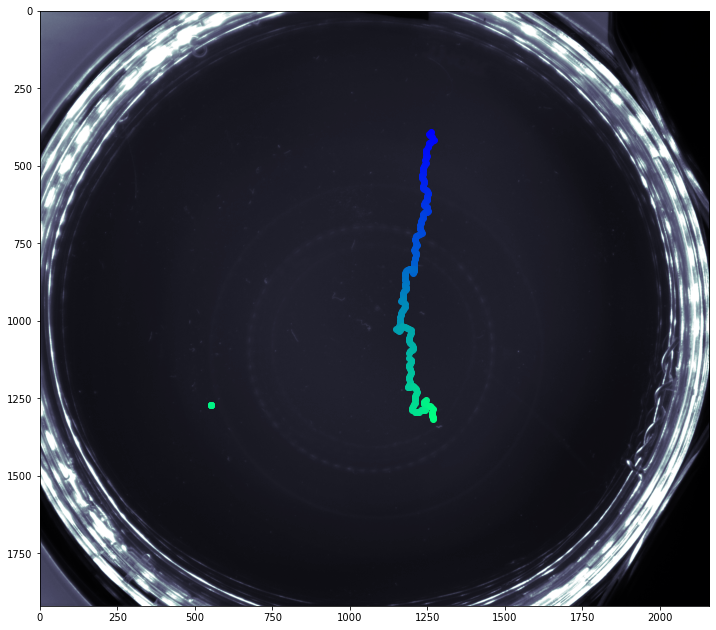

In [9]:
fig,ax = plt.subplots(1)
img = grab_im(cam,None)
ax.imshow(img,cmap='bone')
fig.set_size_inches((12,12))
NPOINTS = track.shape[0]
ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in range(NPOINTS-1):
    ax.scatter(track[i,1],track[i,2])
    ax.set_aspect('equal','box')

# TD

In [35]:
def tabular_Q_agent(direction,light_vec,f_ind,Q_chkpt=None,t_chkpt=0,delay=0,alpha=.05,gamma=0.5,total_time=600,track_time=10,ht_time=3):
    # Fills in a value table theta x light, where light is discretized as in light_vec.
    # delay is how much time in sec between each sample
    # alpha is the learning rate for averaging
    # total_time is in seconds
    # direction is target direction.
    
    # Q_chkpt and t_chkpt are to continue previous trials. Q_chkpt takes the last np array of Q values and 
    # t_chkpt is the approximate last time.
    
    data_dir = './Data/'
    
    NUM_DEGS = 12 # 12 for 30 degree increments
    DEG_INCR = int(360/NUM_DEGS)
    
    def get_eps(t, start=1, end=.1, tau=total_time/4):
        # Returns the epsilon value at t given a start eps, end, and time constant
        # For exponential decay:
        #return (start-end)*np.exp(-t/tau) + end  
        # For constant (good for initial tests):
        return .1
    
    
    # Initialization block
    if Q_chkpt is None:
        Q_table = np.random.randn(NUM_DEGS,NUM_DEGS,len(light_vec))  # random init for now
    else:
        Q_table = Q_chkpt
    Q_obs = [[[[] for i in range(2)] for j in range(NUM_DEGS)] for k in range(NUM_DEGS)] # keep track of updates
        # The 24's above are the number of options [-180,180) in increments of 15
    track = []
    rewards = []
    bg = bgs[0]    
    START = True
    state_inds = [0,0]
    
    # Initialize starting points to junk
    head,old_loc = [1,1],[2,2]

    # Initialize all timers
    elapsed = Timer(total_time)
    track_el = Timer(track_time)
    ht_el = Timer(ht_time)  
    
    while not elapsed.check(): 
        
        # Collect image and make sure worm exists
        img = grab_im(cam,bg)
        worms = find_worms(img,templates,bodies,ref_pts=[head],num_worms=1)
        
        if worms is None:
            task.write(0)
            bg = bgs[0]
            continue
        worm = worms[0]
        head = worm['endpts'][:,0]
        
        
        # Update table block
        # light_ind and state_ind should still be from previous loop
        if START:
            reward = 0
        else:
            reward = proj(worm['loc']-last_loc, [np.cos(direction*pi/180),-np.sin(direction*pi/180)]) # Get reward
            if np.isnan(reward) or np.abs(reward)>10:
                reward = 0
        old_state_inds = state_inds
        last_loc = worm['loc']
        rewards.append(reward)
        
        # finding state
        body_dir = relative_angle(worm['body'],direction)
        head_body = relative_angle(worm['angs'][0],worm['body'])
        state_inds = [int((body_dir+180)//DEG_INCR), int((head_body+180)//DEG_INCR)]
        
        if not START:
            # Q table update step:
            # Q_t+1 (s,a) <- Q_t(s,a) + alpha([r+gamma*max_a'(Q_t(s',a'))] - Q_t(s,a))
            Q_table[old_state_inds[0],old_state_inds[1],light_ind] = \
                Q_table[old_state_inds[0],old_state_inds[1],light_ind] + \
                alpha*((reward+gamma*np.max(Q_table[state_inds[0],state_inds[1],:])) - \
                       Q_table[old_state_inds[0],old_state_inds[1],light_ind])
            
            Q_obs[old_state_inds[0]][old_state_inds[1]][light_ind].append(reward)

        
        # Light selection and action block
        eps = get_eps(elapsed.t+t_chkpt)
        if np.random.random() < eps or START:
            light_ind = random.choice(range(len(light_vec)))
            light = light_vec[light_ind]
            START = False
        else:
            # Choose greedy action
            light_ind = np.argmax(Q_table[state_inds[0],state_inds[1],:])
            light = light_vec[light_ind]
        task.write(light)
        bg = bgs[light_ind]
        
        
        # Tracking block
        if track_el.check():
            track.append(np.hstack([elapsed.t,worm['loc']]))
            #print('Time',int(elapsed.t)+t_chkpt,'\tang:',int(worm['body']),'loc:',worm['loc'])
            #print('\tReward:',round(reward,3))
            with open(data_dir+'Qtab_running'+f_ind+'.json','wb') as f:
                pickle.dump(Q_table, f)
            with open(data_dir+'Qobs_running'+f_ind+'.json','wb') as f:
                pickle.dump(Q_obs, f)
            with open(data_dir+'Track_running'+f_ind+'.json','wb') as f:
                pickle.dump(track, f)
            with open(data_dir+'Rewards_running'+f_ind+'.json','wb') as f:
                pickle.dump(rewards, f)

        if ht_el.check():
            head,SWITCH = ht_quick(worm,old_loc)
            old_loc = worm['loc']
#             if SWITCH:
#                 print('\t\tSwitched')
        
        # Update maintenance variables and step delay
        elapsed.update()
        track_el.update()
        ht_el.update()
        time.sleep(delay)
    
    task.write(0)
    return np.array(track),Q_table,np.array(rewards)

On hour: 0


C:\Users\ccli3\Documents\Research\20_09_07_NewPC\Worms4TF\improc.py:205: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


On hour: 1


C:\Users\ccli3\Documents\Research\20_09_07_NewPC\Worms4TF\improc.py:205: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


On hour: 2


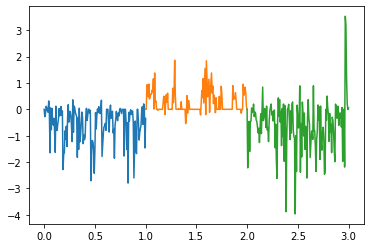

In [36]:
data_dir = './Data/'

for hr in range(3): # Run for many hours, fingers crossed
    print('On hour:',hr)
    flabel = '908_'+str(hr)
    Qtab = None
    
    bgs = make_vec_bg(cam,task,[0,1],total_time=20)
    track,Qs,rewards = tabular_Q_agent((30*hr)%360,[0,1],flabel,Q_chkpt=Qtab,t_chkpt=3600*hr,alpha=0.01,total_time=30)
    
    with open(data_dir+'Qtab_'+flabel+'.json','wb') as f:
        pickle.dump(Qs, f)
    with open(data_dir+'Track_'+flabel+'.json','wb') as f:
        pickle.dump(track, f)
    with open(data_dir+'Rewards_'+flabel+'.json','wb') as f:
        pickle.dump(rewards, f)
    
    Qtab = np.load(data_dir+'Qtab_'+flabel+'.json',allow_pickle=True)
    
    plt.plot(np.linspace(hr,hr+1,len(rewards)),rewards)